In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 13

@author: yaning
"""

import pickle
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
class Params:
    def __init__(self):
        self.u_se_ampa = 0.5
        self.u_se_nmda = 0.5
        self.u_se_gaba = 0.5
        self.tau_rec_ampa = 5.0
        self.tau_rec_nmda = 12.0
        self.tau_rec_gaba = 12.0
        # self.tau_rec_gaba = 3.0
        self.tau_rise_ampa = 15.0
        # self.tau_rise_ampa = 50.0
        self.tau_rise_nmda = 150.0
        self.tau_rise_gaba = 15.0
        self.learning_rate = 1.0
        self.weight_scale = 1.0

params = Params()

In [3]:
def check_fire_lower(mp):
    activeness = (mp > 20).float()
    return activeness

In [28]:


path = "/home/yaning/Documents/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# with open(path + "fire_data_mnst_two.pkl", "rb") as f:
with open(path + "Spiking_add_files/fire_data_mnst_nine.pkl", "rb") as f:
    fire_data = pickle.load(f)

train = False
keep_learning = False
train_file = "train_multi_E20_zipper.pkl"

fire_data = torch.tensor(fire_data, device=device).float()
# fire_data = fire_data[5]
one_pic = fire_data

In [29]:



# parameters
gMax_Na = 120
rE_Na = 115

gMax_K = 36
rE_K = -12

gMax_leaky = 0.3
rE_leaky = 10.6

deltaTms = 0.05
Cm = 1
pointCount = fire_data.shape[-1]

# siemens unit n_s
# gMax_AMPA = 0.00072
# gMax_NMDA = 0.0012
# gMax_GABA = 0.0004

gMax_AMPA = 0.00072 
gMax_NMDA = 0.0012
gMax_GABA = 0.004
# gMax_GABA = 0.006

# # below are from the book
# gMax_AMPA = 0.72
# gMax_NMDA = 1.2
# gMax_GABA = 0.04

rE_AMPA = 70
rE_NMDA = 70
rE_GABA = 0

mg = 0.01
# mg = 1.2

threshold = -50 + 70
current_threshold = -200


# # guesses
# u_se = torch.tensor([0.9, 0.9, 0.9], device=device)
# tau_rec = torch.tensor([5, 12, 12], device=device)
# guesses
u_se = torch.tensor([params.u_se_ampa, params.u_se_nmda, params.u_se_gaba], device=device)
tau_rec = torch.tensor([params.tau_rec_ampa, params.tau_rec_nmda, params.tau_rec_gaba], device=device)
tau_rec = tau_rec

# below from paper 
tau_pre = torch.tensor([20, 20, 20], device=device)
tau_pre = tau_pre
tau_decay = torch.tensor([2.4, 100, 7], device=device)
tau_decay = tau_decay

# rise has to be quicker than decay, tau needs to be bigger (negative deri)
# tau_rise = torch.tensor([1, 50, 3], device=device)
tau_rise = torch.tensor([params.tau_rise_ampa, params.tau_rise_nmda, params.tau_rise_gaba], device=device)
tau_rise = tau_rise
# guesses
# learning_rate = 100
# weight_scale = 10

learning_rate = params.learning_rate
weight_scale = params.weight_scale


# generate the exponential decrease with time gap values
gaps = torch.arange(400, 0, -1, device=device).unsqueeze(0).expand(3,400)
temp_tau_pre = tau_pre.unsqueeze(-1)
weight_values_matrix = torch.exp(-gaps/temp_tau_pre)

for _ in range(5):
    weight_values_matrix = weight_values_matrix.unsqueeze(1)


def update_states(mp, current_states, deltaTms=0.05):
        m_alpha = .1*((25-mp) / (torch.exp((25-mp)/10)-1))
        m_beta = 4*torch.exp(-mp/18)
        n_alpha = .01 * ((10-mp) / (torch.exp((10-mp)/10)-1))
        n_beta = .125*torch.exp(-mp/80)
        h_alpha = .07*torch.exp(-mp/20)
        h_beta = 1/(torch.exp((30-mp)/10)+1)

        alphas = torch.stack([m_alpha, n_alpha, h_alpha], dim=0)
        betas = torch.stack([m_beta, n_beta, h_beta], dim=0)

        alpha_states = alphas*(1-current_states)
        beta_states = betas*current_states

        new_states = current_states + deltaTms*(alpha_states - beta_states)

        return new_states

def broadcast_params(param, target):
    # param = param[:,None]*torch.ones_like(target)[None,...]
    new_shape = (3,) + (1,)*(target.dim()-1)
    param = param.view(new_shape)
    param = param.expand_as(target)
    return param

def broadcast_mp(mp, connection_matrix):
    num_missing_dim = connection_matrix.dim() - mp.dim()
    mp = mp.view(*([1]*num_missing_dim), *mp.shape)
    mp = mp.expand_as(connection_matrix)
    return mp


def runge_kutta(f, y0, h, *arg):
    k1 = f(y0, *arg)
    k2 = f(y0 + h*k1/2, *arg)
    k3 = f(y0 + h*k2/2, *arg)
    k4 = f(y0 + h*k3, *arg)

    next = y0 + h/6*(k1 + 2*k2 + 2*k3 + k4)

    return next

# # deri as deriviation 
# def e_deri(e, on_off):
#     return (1-e)/tau_rec[None,:,None,None] - u_se[None,:,None,None]*on_off

# def g_decay_deri(g_decay, w, e, on_off):
#     return -g_decay/tau_decay[None,:,None,None] + w*e*on_off

# def g_rise_deri(g_rise, w, e, on_off):
#     return -g_rise/tau_rise[None,:,None,None] + w*e*on_off

# deri as deriviation 
def e_deri(e, on_off):
    tau_rec_broad = broadcast_params(tau_rec, e)
    u_se_broad = broadcast_params(u_se, e)
    return (1-e)/tau_rec_broad - u_se_broad*on_off*e

def g_decay_deri(g_decay, w, e, on_off):
    tau_decay_broad = broadcast_params(tau_decay, e)
    return -g_decay/tau_decay_broad + w*e*on_off

def g_rise_deri(g_rise, w, e, on_off):
    tau_rise_broad = broadcast_params(tau_rise, e)
    return -g_rise/tau_rise_broad + w*e*on_off

def update_gPs(es, ws, g_decays, g_rises, fires, recurrent, deltaTms=0.05):
    # cycle is how many layers it connects 
    cycle = len(es)
    new_es = []
    new_g_decays = []
    new_g_rises = []
    gPs = []
    
    for i in range(cycle):

        fire = fires[i]
        fire = fire.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        fire = fire.expand(*es[i].shape)

        if recurrent and i == 0:
            e = es[i]
            e.fill_(1)
        else:
            e = runge_kutta(e_deri, es[i], deltaTms, fire)
        if (e < 0).any():
            print("e negative")
            e[e < 0] = 0


        # deltaTms * 10 is not good, when try to find the right params need to delete this
        g_decay = runge_kutta(g_decay_deri, g_decays[i], deltaTms, ws[i], e, fire)
        g_rise = runge_kutta(g_rise_deri, g_rises[i], deltaTms, ws[i], e, fire)


        gP = g_rise - g_decay
        if (gP < 0).any():
            print("gP negative")
            gP[gP < 0] = 0
            
        new_es.append(e)
        new_g_decays.append(g_decay)
        new_g_rises.append(g_rise)
        gPs.append(gP)

    return new_es, new_g_decays, new_g_rises, gPs


def initialise(*args):
    d = args[0]

    # cells, states, mp are fine with only individual cells
    cells = torch.zeros((d, d), device=device)

    m_states = cells.clone()
    m_states.fill_(0.061956531255774015)

    n_states = cells.clone()
    n_states.fill_(0.3384883478113268)

    h_states = cells.clone()
    h_states.fill_(0.5484107720738856)

    states = torch.stack([m_states, n_states, h_states], dim=0)

    mp = cells.clone()
    mp.fill_(1.3458754117369027)

    # the synapses properties are not individual cell but 
    # shape as the connections

    es = []
    ws = []
    g_decays = []
    g_rises = []

    # if randomize:
    for arg in args[1:]:
        gaussian = arg[1]
        weight = arg[2]
        arg = arg[0]

        muster = torch.zeros(arg.shape, device=device)

        e = muster.clone()
        e.fill_(1)
        es.append(e)

        #---------------------about weight---------------------------------------
        if not gaussian:
            w = torch.rand(*arg.shape[1:], device=device)*weight
        else:
            w = torch.ones(*arg.shape[1:], device=device)*weight

        shape = [3] + [1]*w.ndim
        w = w.unsqueeze(0).repeat(shape)
        # w = torch.rand(*arg.shape, device=device)*weight_scale

        w = w*arg


        ws.append(w)


        #-----------------------------------------------------------------------

        g_decay = muster.clone()
        g_decay.fill_(1)
        g_decay = g_decay*arg
        g_decays.append(g_decay)

        g_rise = muster.clone()
        g_rise.fill_(1)
        g_rise = g_rise*arg
        g_rises.append(g_rise)


    # normalise ws
    



    return cells, states, mp, es, ws, g_decays, g_rises

def check_fire(mp):
    activeness = (mp > threshold).float()
    return activeness


def update_I_E(mp, gPs, states):

    # generate currents based on gPs
    cycle = len(gPs)
    muster = torch.zeros_like(mp)
    AMPA_currents = muster.clone()
    NMDA_currents = muster.clone()
    GABA_currents = muster.clone()
    
    for i in range(cycle):
        temp_mp = broadcast_mp(mp, gPs[i])

        AMPA_currents += (gMax_AMPA*gPs[i][0,...]*(temp_mp-rE_AMPA)).sum(dim=tuple(range(temp_mp.ndim - 2)))
        NMDA_currents += (gMax_NMDA*gPs[i][1,...]*(1/(1+mg*torch.exp(-0.062*temp_mp)/3.57))*(temp_mp-rE_NMDA)).sum(dim=tuple(range(temp_mp.ndim - 2)))
        GABA_currents += (gMax_GABA*gPs[i][2,...]*(temp_mp-rE_GABA)*(-1)).sum(dim=tuple(range(temp_mp.ndim - 2)))



    Ireceptors = AMPA_currents + NMDA_currents + GABA_currents

    # Ireceptors[Ireceptors >= 0] = 0.0


    overflow_neurons = (Ireceptors <= current_threshold).float()

    
    sodium_currents = gMax_Na*torch.pow(states[0], 3) * states[2]*(mp-rE_Na)
    potassium_currents = gMax_K*torch.pow(states[1], 4)*(mp-rE_K)
    leaky_currents = gMax_leaky*(mp-rE_leaky)

    total_I = - sodium_currents - potassium_currents - leaky_currents - Ireceptors


    mp = mp + deltaTms*total_I/Cm
    # mp = torch.clamp(mp, max=50.0)

    return mp


# initialise everything

pixel_num = 10
feature_num = 8
E_num = 20
I_num = 4
Out_num = 5


#-----------connection matrices-------------
# ampa
In_con_E = torch.zeros(3, pixel_num, pixel_num, feature_num, E_num, E_num, device=device)
# all-to-all  connections
In_con_E[0].fill_(1.)

# the later two E_nums are the one sending out the connections/the center
# ampa and nmda
E_con_E = torch.zeros(E_num, E_num, E_num, E_num, device=device)
sigma_E_E = 2
max_E_E = 4.5
for i in range(E_num):
    for j in range(E_num):
        for k in range(E_num):
            for l in range(E_num):
                project_center_x = k
                project_center_y = l

                # dx = min(abs(project_center_x - i), E_num-abs(project_center_x - i))
                # dy = min(abs(project_center_y - j), E_num-abs(project_center_y - j))
                
                dx = abs(project_center_x - i)
                dy = abs(project_center_y - j)

                euc_distance = math.sqrt(dx**2 + dy**2)
                

                # euc_distance = math.sqrt((project_center_x - i)**2 + (project_center_y - j)**2)
                E_con_E[i,j,k,l] = max_E_E*math.exp(-0.5*(euc_distance/sigma_E_E)**2)
E_con_E = E_con_E.permute(2, 3, 0, 1)
E_con_E = E_con_E.unsqueeze(0).repeat(3,1,1,1,1)
E_con_E[-1] = 0


# E to I connection matrix (p=0.1)
# ampa and nmda 
E_con_I = torch.zeros(E_num, E_num, I_num, I_num, device=device)
num_elements = E_con_I.numel()
num_ones = max(1, int(num_elements * 0.1))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
E_con_I.view(-1)[flat_indices] = 1
E_con_I = E_con_I.unsqueeze(0).repeat(3,1,1,1,1)
E_con_I[-1] = 0

# I to E connection matrix (p=0.024)
# gaba
I_con_E = torch.zeros(I_num, I_num, E_num, E_num, device=device)
num_elements = I_con_E.numel()
num_ones = max(1, int(num_elements * 0.024))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
I_con_E.view(-1)[flat_indices] = 1
I_con_E = I_con_E.unsqueeze(0).repeat(3,1,1,1,1)
I_con_E[0] = 0
I_con_E[1] = 0

# I to I self connection (p=0.1)
# gaba
I_con_I = torch.zeros(I_num, I_num, I_num, I_num, device=device)
num_elements = I_con_I.numel()
num_ones = max(1, int(num_elements * 0.1))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
I_con_I.view(-1)[flat_indices] = 1
I_con_I = I_con_I.unsqueeze(0).repeat(3,1,1,1,1)
I_con_I[0] = 0
I_con_I[1] = 0

# E to Out connection
# ampa
E_con_Out = torch.zeros(E_num, E_num, Out_num, Out_num, device=device)
sigma_E_Out = 2
max_E_Out = 1
# find the center point from Output to E
ratio = E_num/Out_num
for i in range(E_num):
    for j in range(E_num):
        for k in range(Out_num):
            for l in range(Out_num):
                project_center_x = k*ratio
                project_center_y = l*ratio

                euc_distance = math.sqrt((project_center_x - i)**2 + (project_center_y - j)**2)
                E_con_Out[i,j,k,l] = max_E_Out*math.exp(-0.5*(euc_distance/sigma_E_Out)**2)
E_con_Out = E_con_Out.unsqueeze(0).repeat(3,1,1,1,1)
E_con_Out[1] = 0
E_con_Out[2] = 0


#----------E---------------------
E_cells, E_states, E_mp, E_es, E_ws, E_g_decays, E_g_rises = initialise(E_num, 
                                                                        [In_con_E, False, weight_scale], 
                                                                        [E_con_E, True, weight_scale], 
                                                                        [I_con_E, False, weight_scale*16])
# E_ws = normalise_weight(E_ws)
# this normalise step is not very necessary but meh 
sums = E_ws[0][0].sum(dim=(0,1,2), keepdim=True)   # sum over presyn dims for each post neuron
E_ws[0][0] = E_ws[0][0]/sums*learning_rate*10


#----------I-----------------
I_cells, I_states, I_mp, I_es, I_ws, I_g_decays, I_g_rises = initialise(I_num, 
                                                                        [E_con_I, False, weight_scale], 
                                                                        [I_con_I, False, weight_scale])
# I_ws = normalise_weight(I_ws)


#-----------Output-------------
Out_cells, Out_states, Out_mp, Out_es, Out_ws, Out_g_decays, Out_g_rises = initialise(Out_num, 
                                                                                        [E_con_Out, True, weight_scale])
# Out_ws = normalise_weight(Out_ws)

# # ------------------set to a good learning state-----------------------------------------
# if train and not keep_learning:
#     with open(path + "/Spiking_NN/datasets/SNN_states/pretty_good_states.pkl", "rb") as f:
#         test_states = pickle.load(f)
    
#     # I_ws = test_states["initial_I_ws"]
#     E_ws = test_states["initial_E_ws"]

#-------------------keep learning----------------------------------------------------------
if train and keep_learning:
    with open(path + "/Spiking_NN/datasets/SNN_states/" + train_file, "rb") as f:
        last_states = pickle.load(f)
    
    # I_ws = test_states["initial_I_ws"]
    E_ws = last_states["E_ws"]

if train:
    states = {}
    initial_E_ws = []
    for i in E_ws:
        initial_E_ws.append(i.detach().clone())
    states["initial_E_ws"] = initial_E_ws

    initial_I_ws = []
    for i in I_ws:
        initial_I_ws.append(i.detach().clone())
    states["initial_I_ws"] = initial_I_ws

    initial_Out_ws = []
    for i in Out_ws:
        initial_Out_ws.append(i.detach().clone())
    states["initial_Out_ws"] = initial_Out_ws
# -----------------------------------------run-------------------------------------------------


if not train:
    # # use last weights
    with open(path + "Spiking_add_files/" + train_file, "rb") as f:
    # with open(path + "fire_data_gabor_binary.pkl", "rb") as f:
        states = pickle.load(f)
    # E_ws[0][0] = states["E_ws"][0][0]
    E_ws = states["E_ws"]
    # I_ws = states["I_ws"]
    # Out_ws = states["Out_ws"]



dims = list(range(one_pic.ndim))
new_order = [dims[-1]] + dims[:-1]
In_fires = one_pic.permute(new_order)
E_fires = torch.zeros((pointCount, E_num, E_num), device=device)
I_fires = torch.zeros((pointCount, I_num, I_num), device=device)
Out_fires = torch.zeros((pointCount, Out_num, Out_num), device=device)


for t in range(pointCount):
    if t % 1000 == 0:  # every 50 steps
        print(f"Progress: {t}/{pointCount} ({100*t/pointCount:.1f}%)")
    # check mp and which fires then change connected layer activeness
    # Input to E
    In_fire = one_pic[:, :, :, t]

    if E_mp.isnan().any():
        print("oops")
        print(t)
        data = {
            # 'In_fires': In_fires*100,
            'In_fires': In_fires,
            'E_fires': E_fires,
            'I_fires': I_fires,
            'Out_fires': Out_fires
        }

        # with open(path + 'large_files/fires_new.pkl', 'wb') as f:
        #     pickle.dump(data, f)
        


    # add spontaneous firing
    # mask = torch.rand(E_mp.shape) < 0.001
    # E_mp[mask] = spontaneous_mp
    E_fire = check_fire(E_mp)
    E_fire_lower = check_fire_lower(E_mp)
    E_fires[t] = E_fire_lower
    # E_fires[t] = E_fire
    # E_fires[t] = E_mp


    # mask = torch.rand(I_mp.shape) < 0.001
    # I_mp[mask] = spontaneous_mp
    I_fire = check_fire(I_mp)
    # I_fire_lower = check_fire_lower(I_mp)
    # I_fires[t] = I_fire_lower
    # I_fires[t] = I_fire
    I_fires[t] = I_mp
    
    # mask = torch.rand(Out_mp.shape) < 0.001
    # Out_mp[mask] = spontaneous_mp
    Out_fire = check_fire(Out_mp)
    # Out_fire_lower = check_fire_lower(Out_mp)
    # Out_fires[t] = Out_fire_lower
    # Out_fires[t] = Out_fire
    Out_fires[t] = Out_mp


    # -----------------update gPs based on activeness--------------------------------
    # update them by each layer connection, cannot do it at the same time because
    # the shapes are different

    E_states = update_states(E_mp, E_states) 
    E_es, E_g_decays, E_g_rises, E_gPs = update_gPs(E_es, E_ws, E_g_decays, E_g_rises, [In_fire, E_fire, I_fire], 1)


    I_states = update_states(I_mp, I_states)
    I_es, I_g_decays, I_g_rises, I_gPs = update_gPs(I_es, I_ws, I_g_decays, I_g_rises, [E_fire, I_fire], 0)


    Out_states = update_states(Out_mp, Out_states)
    Out_es, Out_g_decays, Out_g_rises, Out_gPs = update_gPs(Out_es, Out_ws, Out_g_decays, Out_g_rises, [E_fire], 0)



    # ------------------generate currents and voltages based on gPs-------------------------------

    E_mp = update_I_E(E_mp, E_gPs, E_states)
    # E_mp, E_ws = update_I_E(E_gPs, E_mp, E_states, E_ws)
    

    I_mp = update_I_E(I_mp, I_gPs, I_states)
    # I_mp, I_ws = update_I_E(I_gPs, I_mp, I_states, I_ws)

    Out_mp = update_I_E(Out_mp, Out_gPs, Out_states)
    # Out_mp, Out_ws = update_I_E(Out_gPs, Out_mp, Out_states, Out_ws)

    
    # -------------------------update weights----------------------------------
    # only In to E
    # get the matrix of needed to change weight from the cons (Q: including the current time step?)
    # take only the 400 time step before, equals to 20ms, which is the learning period in the paper
    # for now update after 400 time steps 
    if train:
        if t >= 400:
            past_pre_fires = In_fires[t-399:t+1,:,:,:]
            # using just multiplication
            interactions = torch.einsum('tijk,ab->ijkabt', past_pre_fires, E_fire)
            dw = (interactions*weight_values_matrix).sum(dim=-1)[0]
            E_ws[0][0] += dw #*(1/(1+0.07*(t-400)))

    # # only normalise the In to E connection's AMPA connection hence the [0][0]
    # # E_ws[0][0] = E_ws[0][0]/E_ws[0][0].sum(dim=(0,1,2), keepdim=True)*weight_scale*5
    sums = E_ws[0][0].sum(dim=(0,1,2), keepdim=True)   # sum over presyn dims for each post neuron
    # # E_ws[0][0] = E_ws[0][0] / sums * (weight_scale * 5 / (E_ws[0][0].shape[2]*E_ws[0][0].shape[3])) #----this step looks weird
    E_ws[0][0] = E_ws[0][0]/sums*learning_rate*10



    # voltages.append(E_mp[10,10].cpu()-70)

data = {
    # 'In_fires': In_fires*100,
    'In_fires': In_fires,
    'E_fires': E_fires,
    'I_fires': I_fires,
    'Out_fires': Out_fires
}

# skip showing the silence part between 600 - 1500
# data = {
#     'In_fires': torch.cat([In_fires[:600]*100,In_fires[1501:2500]*100, In_fires[3200:]], dim=0),
#     'E_fires': torch.cat([E_fires[:600], E_fires[1501:2500], E_fires[3200:]], dim=0),
#     'I_fires': torch.cat([I_fires[:600], I_fires[1501:2500], I_fires[3200:]], dim=0),
#     'Out_fires': torch.cat([Out_fires[:600], Out_fires[1501:2500], Out_fires[3200:]], dim=0)
# }

# data = {
#     'In_fires': In_fires[1600:]*100,
#     # 'In_fires': In_fires,
#     'E_fires': E_fires[1600:],
#     'I_fires': I_fires[1600:],
#     'Out_fires': Out_fires[1600:]
# }

if train:
    after_E_ws = []
    for i in E_ws:
        after_E_ws.append(i.detach().clone())
    states["E_ws"] = after_E_ws
    # states["E_ws"] = E_ws[0][0].detach().clone()
    
    # states = {
    #     "E_ws": E_ws
    #     # "I_ws": I_ws,
    #     # "Out_ws": Out_ws
    # }


    with open(path + 'Spiking_NN/datasets/SNN_states/' + train_file, 'wb') as f:
        pickle.dump(states, f)



Progress: 0/4000 (0.0%)
Progress: 1000/4000 (25.0%)
Progress: 2000/4000 (50.0%)
Progress: 3000/4000 (75.0%)


In [30]:
E_fires = E_fires.cpu()

In [7]:
times = torch.arange(0, 4000)

In [8]:
sum_six_zipper = E_fires.sum(dim=(1,2))

In [31]:
sum_nine_zipper = E_fires.sum(dim=(1,2))

In [25]:
sum_nine.shape

torch.Size([4000])

In [9]:
import numpy as np
from scipy.ndimage import label


def avalanches(fires):
    # Label connected components (blobs)
    labeled_array, num_features = label(fires, structure=np.ones((3,3)))

    # Compute size of each blob (avalanche size)
    blob_sizes = []
    for i in range(1, num_features+1):
        size = np.sum(labeled_array == i)
        blob_sizes.append(size)


    blob_sizes = np.array(blob_sizes)
    labeled_array = np.array(labeled_array)
    return blob_sizes, labeled_array
    # print("Avalanche sizes (number of ones per blob):", blob_sizes)



See the histogram avalanches size and total activities relationship

In [36]:
# per time
total_sizes_nine_zipper = []
labels_nine_zipper = []
for i in range(E_fires[500:].shape[0]):
    blob_sizes, temp_label= avalanches(E_fires[i])

    # limit sizes
    # blob_sizes = blob_sizes[blob_sizes>10]
    blob_sizes = blob_sizes[blob_sizes<10]

    total_sizes_nine_zipper.append(blob_sizes)
    labels_nine_zipper.append(temp_label)


In [11]:
time = []
value = []
for i in range(len(total_sizes_six_zipper)):
    for j in total_sizes_six_zipper[i]:
        time.append(i)
        value.append(j)


In [12]:
df_six_zipper = pd.DataFrame({
    "value": value,
    "time": time
})

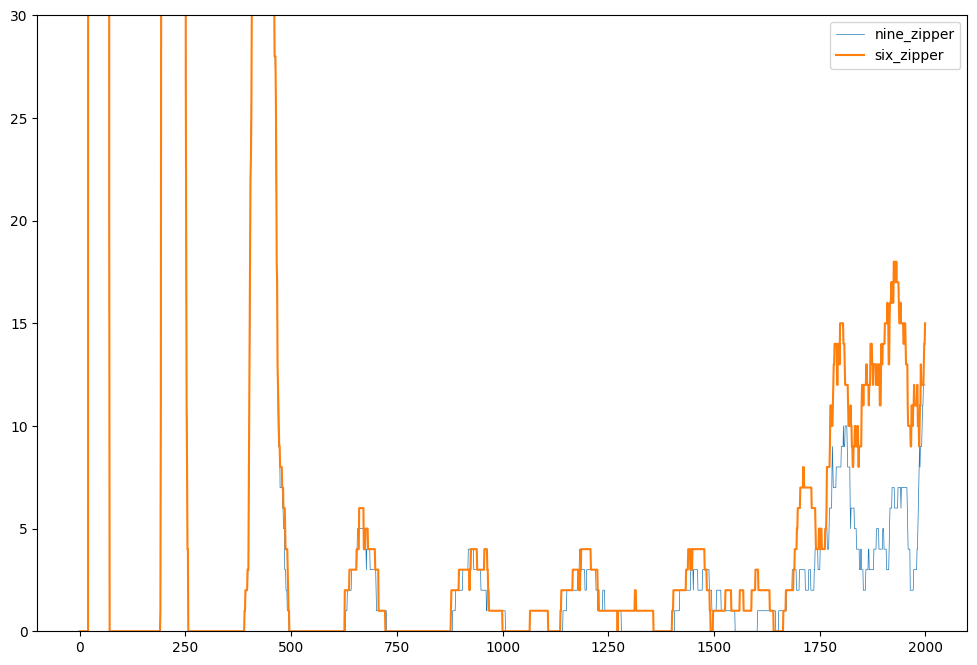

In [32]:
# df["time_num"] = pd.to_numeric(df["time"], errors="coerce")
fig, ax = plt.subplots(figsize=(12, 8))
# sns.scatterplot(data=df[:], x="time", y="value", ax=ax, s=5)
# ax.plot(times[500:], sum_six.cpu()[500:], label='six', lw=0.5)
# ax.plot(times[500:], sum_nine.cpu()[500:], label='nine', lw=0.5)
# ax.plot(times[500:], sum_zero.cpu()[500:], label='zero', lw=0.5)
# ax.plot(times[500:], sum_seven.cpu()[500:], label='seven', lw=0.5)
ax.plot(times[:2000], sum_nine_zipper.cpu()[:2000], label='nine_zipper', lw=0.5)
ax.plot(times[:2000], sum_six_zipper.cpu()[:2000], label='six_zipper', lw=1.5)
ax.set_ylim([0,30])

ax.legend()

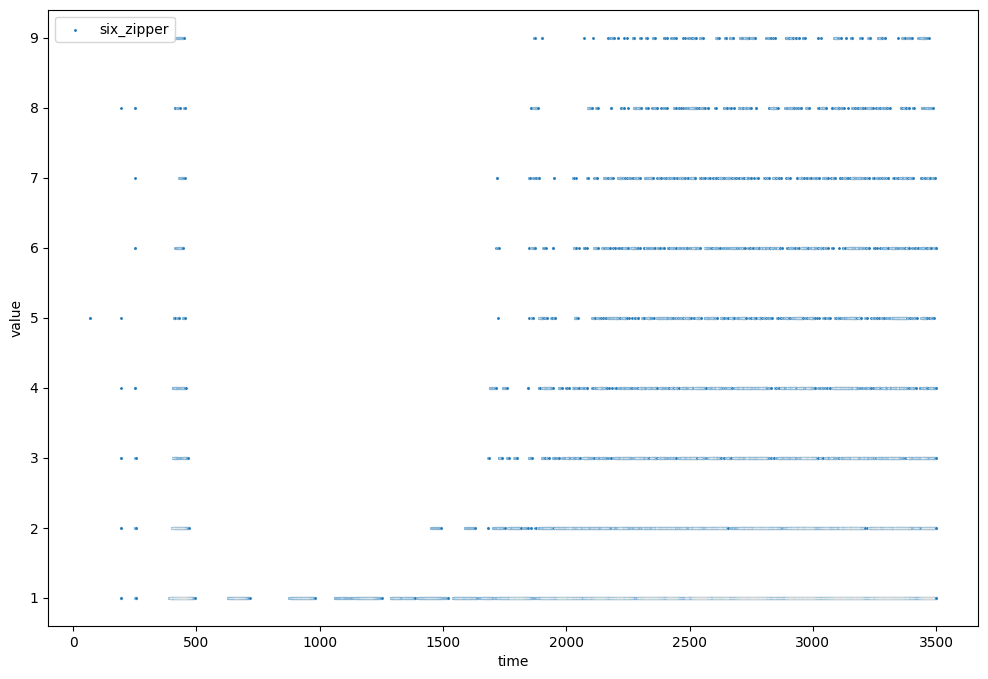

In [48]:
# df["time_num"] = pd.to_numeric(df["time"], errors="coerce")
fig, ax = plt.subplots(figsize=(12, 8))
# sns.scatterplot(data=df_six[:], x="time", y="value", ax=ax, s=5, label="six")
# sns.scatterplot(data=df_nine[:], x="time", y="value", ax=ax, s=5, label="nine")
# sns.scatterplot(data=df_zero[:], x="time", y="value", ax=ax, s=5, label="zero")
# sns.scatterplot(data=df_two[:], x="time", y="value", ax=ax, s=5, label="two")
# sns.scatterplot(data=df_seven[:], x="time", y="value", ax=ax, s=5, label="seven")
# sns.scatterplot(data=df_nine_zipper[:], x="time", y="value", ax=ax, s=5, label="nine_zipper")
sns.scatterplot(data=df_six_zipper[:], x="time", y="value", ax=ax, s=5, label="six_zipper")
ax.legend()
# ax.plot(times[500:], sum_six.cpu()[500:], label='same', lw=0.5)

In [51]:
labels_nine_zipper[950]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [74]:
cats = times.astype(str).unique()

AttributeError: 'Tensor' object has no attribute 'astype'

In [ ]:
time_to_cat = 

Avalanches sizes and probabilities/counts

In [ ]:
# not per time
total_sizes = []
for i in range(E_fires[500:].shape[0]):
    blob_sizes = avalanches(E_fires[i])

    # limit sizes
    blob_sizes = blob_sizes[blob_sizes>10]
    # blob_sizes = blob_sizes[blob_sizes<100]
    
    total_sizes = np.concatenate((total_sizes, blob_sizes))

In [36]:
new = []
for i in total_sizes:
    if i <= 100:
        new.append(i)

In [37]:
unique_sizes, counts = np.unique(new, return_counts= True)

In [38]:
log_sizes = np.log(unique_sizes)
log_counts = np.log(counts)

In [39]:

df = pd.DataFrame({
    "log_size": log_sizes,
    "log_count": log_counts
})

In [40]:
from scipy.stats import linregress
res = linregress(df["log_size"], df["log_count"])

In [41]:
res.rvalue

np.float64(-0.8735371654269758)

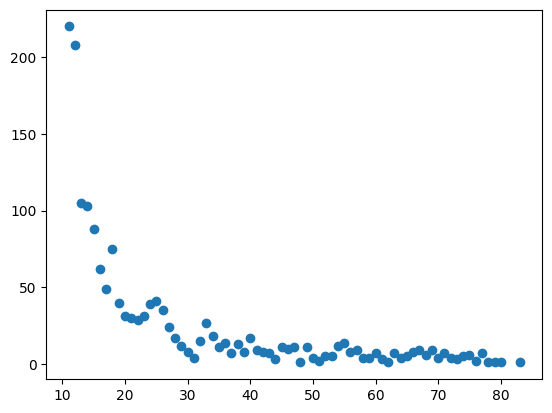

In [42]:
plt.plot(unique_sizes, counts, "o")
# plt.savefig("size_count.png", dpi=300, bbox_inches="tight")

<Axes: xlabel='log_count', ylabel='log_size'>

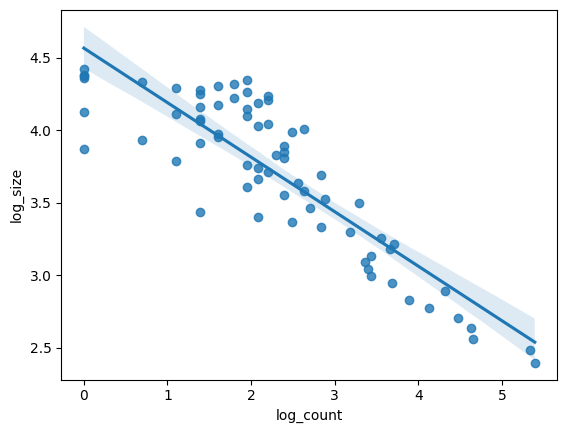

In [43]:
sns.regplot(data=df, x="log_count", y="log_size")
# plt.savefig("log_log.png", dpi=300, bbox_inches="tight")

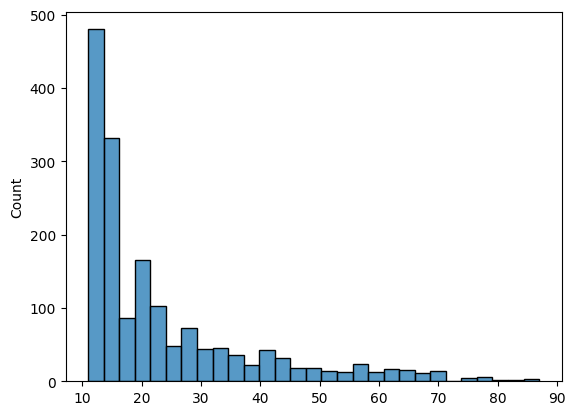

In [42]:
sns.histplot(new)
plt.savefig("histo.png", dpi=300, bbox_inches="tight")

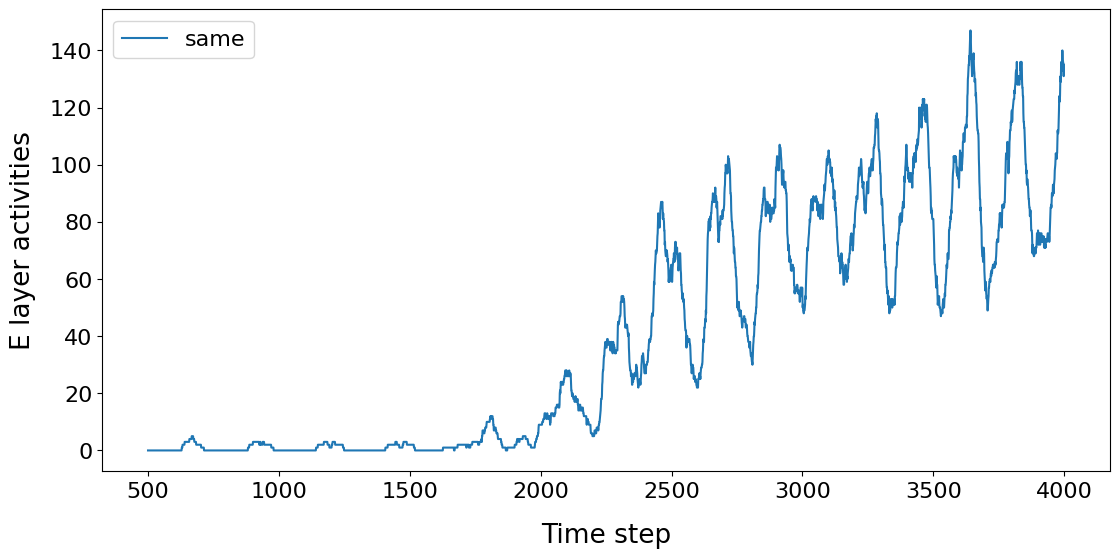

In [48]:
plt.figure(figsize=(13, 6))
font_size = 16

# plt.plot(times[500:], sum_six.cpu()[500:], label='Same')
plt.plot(times[500:], sum_nine.cpu()[500:], label='same')
# plt.plot(times[500:], sum_zero.cpu()[500:], label='Different')
# plt.plot(times[500:], sum_one.cpu()[500:], label='Different')
# plt.plot(times, sum_six.cpu()[500:])
plt.legend(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xlabel('Time step', fontsize=font_size+3, labelpad=15)
plt.ylabel('E layer activities', fontsize=font_size+3, labelpad=10)
plt.savefig('EEG.png', dpi=300, bbox_inches='tight')

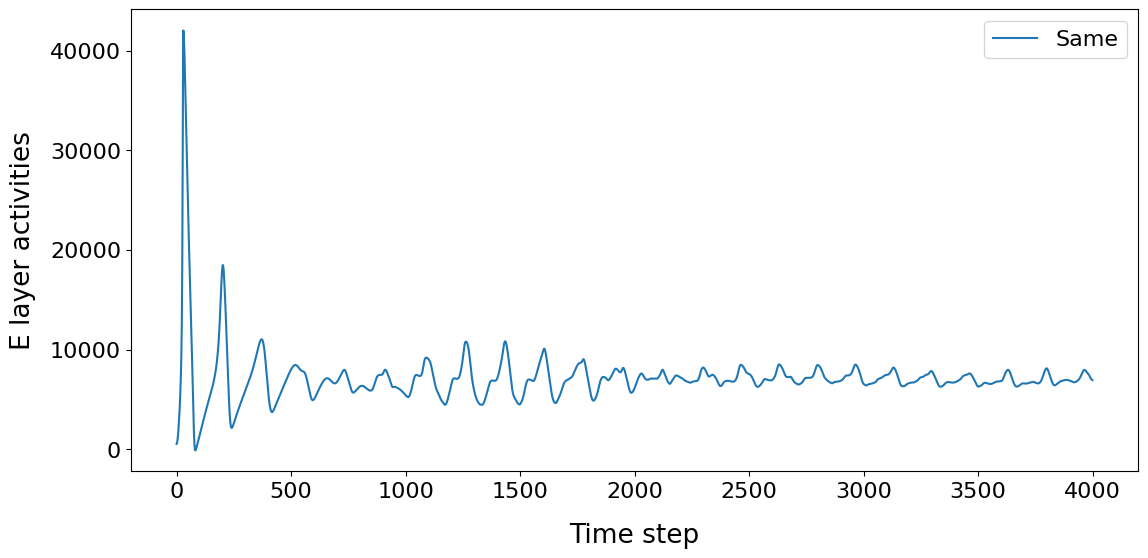

In [51]:

plt.figure(figsize=(13, 6))
font_size = 16

plt.plot(times[:], sum_six.cpu()[:], label='Same')
# plt.plot(times, sum_four.cpu()[500:], label='Different')
# plt.plot(times, sum_six.cpu()[500:])
plt.legend(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xlabel('Time step', fontsize=font_size+3, labelpad=15)
plt.ylabel('E layer activities', fontsize=font_size+3, labelpad=10)
plt.savefig('EEG.png', dpi=300, bbox_inches='tight')

In [119]:
size = 4
sum_E_fires = torch.zeros((4000,5,5))
for i in range(5):
    for j in range(5):
        sub_array = E_fires[:, i*size:i*size+size, j*size:j*size+size]
        temp_sum = sub_array.sum(dim=(1,2))
        sum_E_fires[:,i,j] = temp_sum

In [120]:
sum_E_fires.shape

torch.Size([4000, 5, 5])

<Axes: >

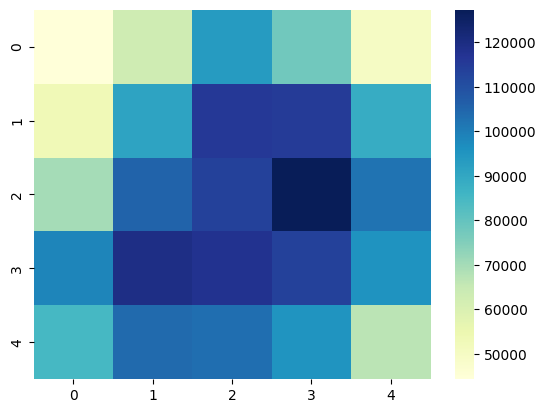

In [123]:

sns.heatmap(sum_E_fires[2000:2500].sum(dim=0).cpu(), annot=False, cmap="YlGnBu")

In [7]:
sum_nine_another = E_fires.sum(dim=(1,2)) 
# maxi = torch.max(sum[1000:1250])
# sum = sum[500:2000].sum()
# if sum > 2500:
#     print(sum)
#     print("nine")

In [19]:
test_out = Out_fires

In [20]:
test_out.shape

torch.Size([4000, 5, 5])

<Axes: >

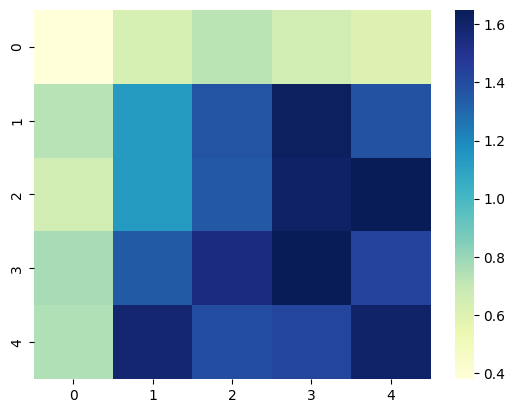

In [26]:
sns.heatmap(test_out[750].cpu(), annot=False, cmap="YlGnBu")

In [133]:
dict = {
    'nine': sum_nine_another,
    'four': sum_four
}

In [134]:
with open(path + "classi_4_9.pkl", "wb") as f:
    pickle.dump(dict, f)

In [3]:
with open(path + "classi_4_9.pkl", "rb") as f:
    EEGs = pickle.load(f)

In [4]:
EEGs

{'nine': tensor([  0.,   0.,   0.,  ..., 156., 165., 163.], device='cuda:0'),
 'four': tensor([  0.,   0.,   0.,  ..., 120., 120., 119.], device='cuda:0')}

In [12]:
# times = torch.arange(500, 4000)
times = torch.arange(0, 4000)

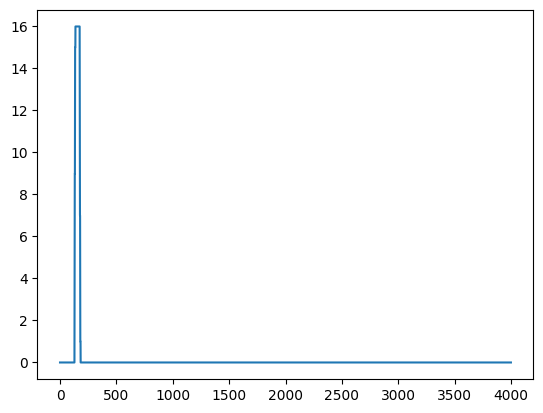

In [13]:
plt.plot(times, test_out.cpu(), label='Same')

In [6]:
sum_nine = EEGs['nine']
sum_four = EEGs['four']

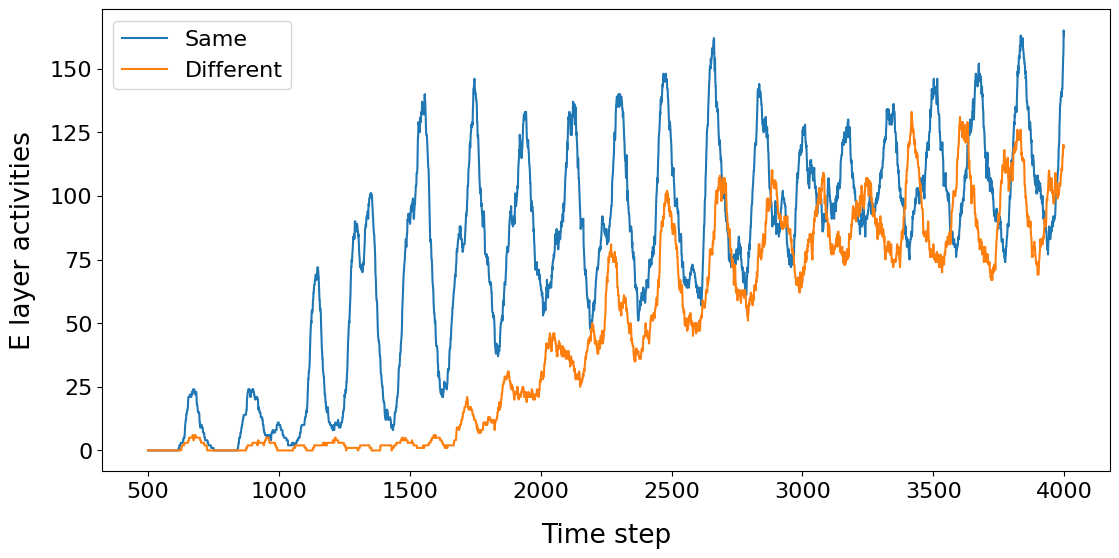

In [13]:

plt.figure(figsize=(13, 6))
font_size = 16

plt.plot(times, sum_nine.cpu()[500:], label='Same')
plt.plot(times, sum_four.cpu()[500:], label='Different')
# plt.plot(times, sum_six.cpu()[500:])
plt.legend(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xlabel('Time step', fontsize=font_size+3, labelpad=15)
plt.ylabel('E layer activities', fontsize=font_size+3, labelpad=10)
plt.savefig('EEG.png', dpi=300, bbox_inches='tight')

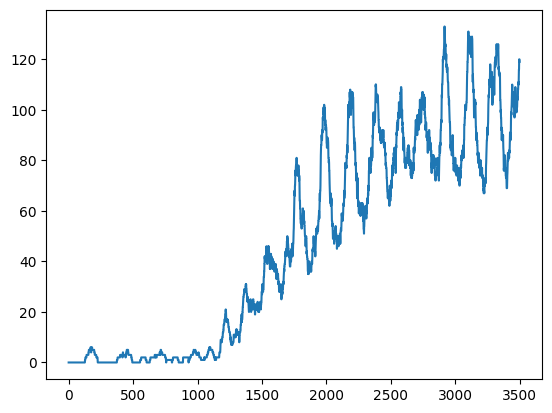

In [96]:
plt.plot(sum_four.cpu()[500:])

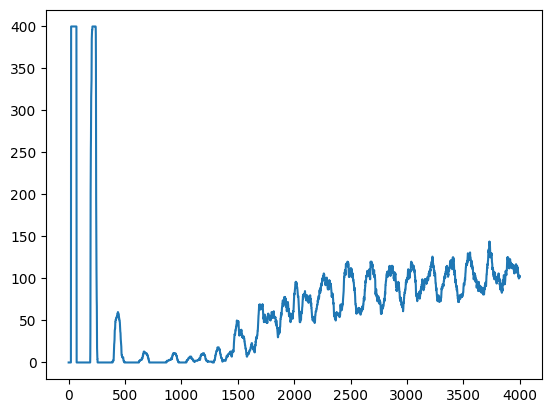

In [73]:
plt.plot(sum.cpu())

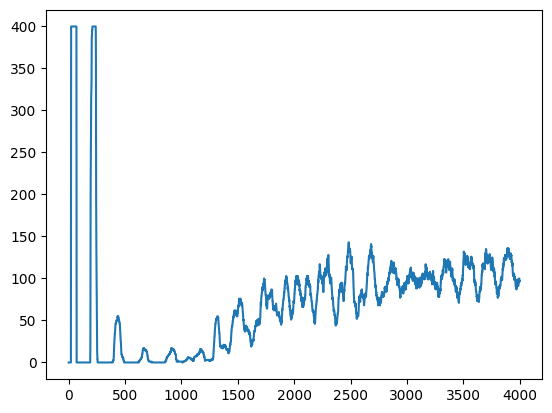

In [51]:
plt.plot(sum.cpu())

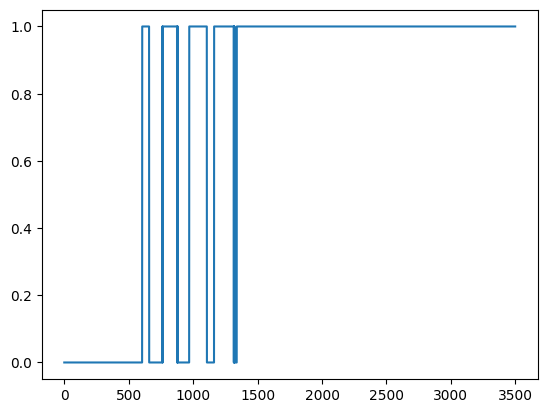

In [166]:
plt.plot(sum.cpu()[500:]>40)

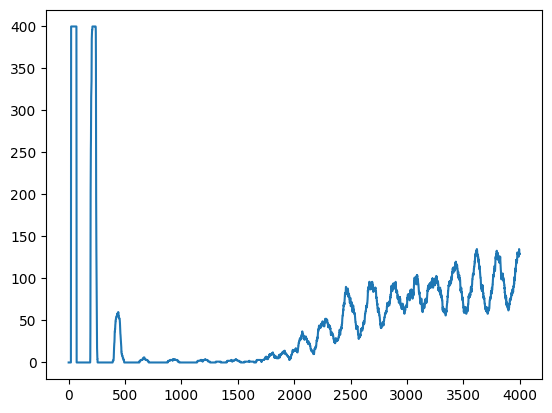

In [159]:
plt.plot(sum.cpu())

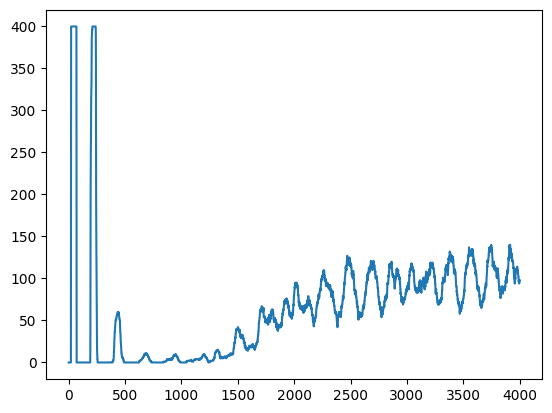

In [151]:
plt.plot(sum.cpu())

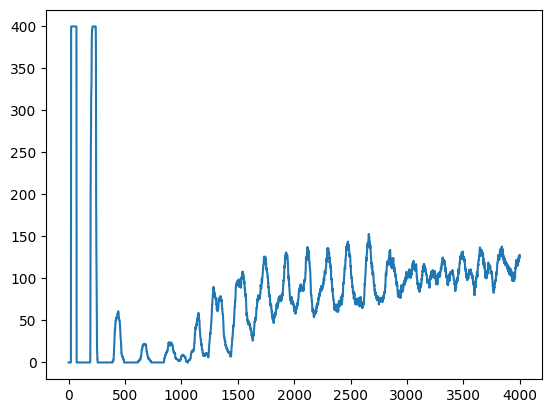

In [147]:
plt.plot(sum.cpu())

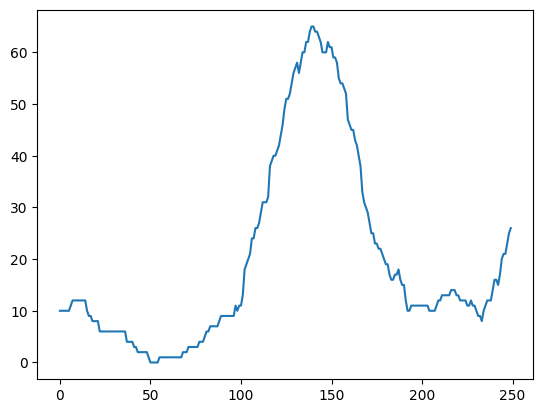

In [26]:
plt.plot(sum_nine_fourth[1000:1250])

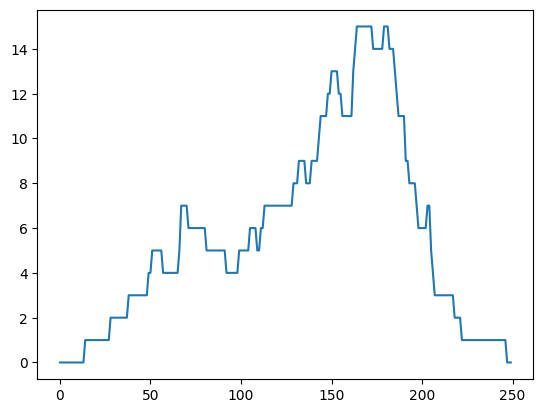

In [27]:
plt.plot(sum_zero[1000:1250])

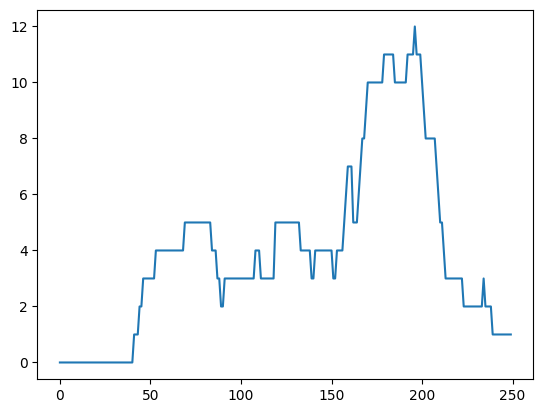

In [28]:
plt.plot(sum_one[1000:1250])

In [ ]:
sum_zero = E_fires[:].sum(dim=(1,2)).cpu()

In [ ]:
sum_one = E_fires[:].sum(dim=(1,2)).cpu()

In [ ]:
sum_nine_fourth = E_fires[:].sum(dim=(1,2)).cpu()

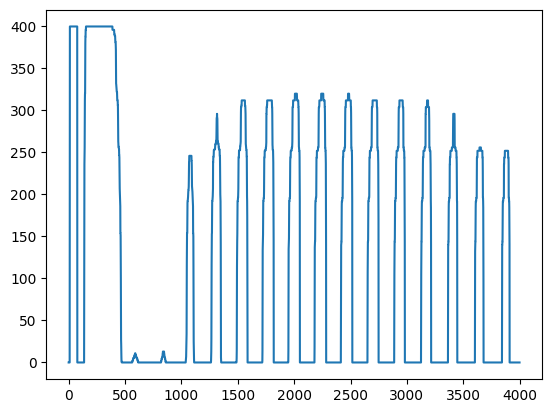

In [109]:
plt.plot(sum.cpu())

<Axes: >

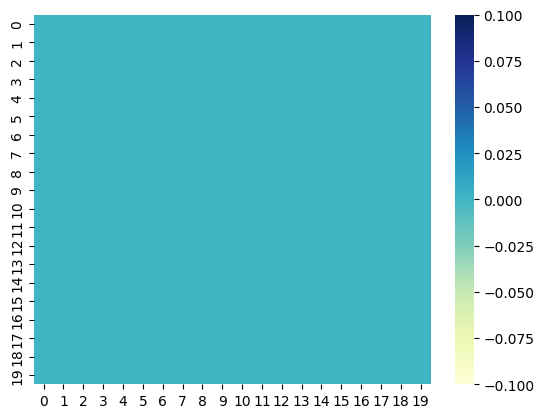

In [100]:
import seaborn as sns
sns.heatmap(fires[1020].cpu(), annot=False, cmap="YlGnBu")